# TODO
-  WeightedRandomSampler
- weighted binary cross entropy loss
- transformations
- https://arxiv.org/pdf/1711.05225.pdf



In [1]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import sklearn
from sklearn import metrics
import pydicom

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
PATH = '/home/paperspace/data/pneumonia/'

In [3]:
file2target = pd.read_csv(f'{PATH}file2target.csv')
train_n = file2target.shape[0]
train_n

25684

In [4]:
val_idxs = get_cv_idxs(train_n)
val_idxs.shape

(5136,)

In [5]:
bs  = 256
arch = resnet50
sz=128

In [103]:
class OverSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, counts):
        indices =[]
        for idx, cnt in enumerate(counts):
            indices = indices +[idx]*int(cnt)
        self.ind_arr = np.array(indices)
        np.random.shuffle(self.ind_arr)
    
    def __len__(self):
        return len(self.ind_arr)
    
    def __iter__(self):
        return iter(self.ind_arr)

In [127]:
def get_data(sz):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train_png512', f'{PATH}file2target.csv',
                                   val_idxs=val_idxs, bs=bs, tfms=tfms)
    train_ds = data.trn_ds
    train_dl = data.trn_dl
    all_y=np.ndarray(0)
    for x,y in train_dl.__iter__():
        all_y =np.append(all_y, y.cpu().numpy())

    weights = all_y*3 + 1
    sampler = OverSampler(weights)
    train_dl.sampler = sampler
    train_dl.batch_sampler=torch.utils.data.sampler.BatchSampler(sampler,bs,False)
    return data

In [133]:
learn = ConvLearner.pretrained(arch, get_data(sz), precompute=True, ps=0.5)

 90%|█████████ | 73/81 [00:03<00:00, 19.70it/s, loss=1.07] 


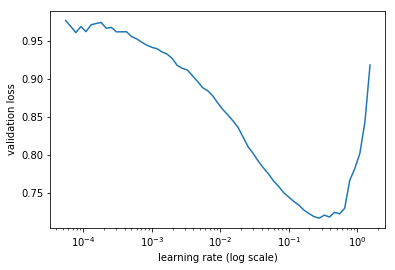

In [134]:
learn.lr_find()
learn.sched.plot()

In [135]:
%time learn.fit(1e-2, 5)

epoch      trn_loss   val_loss   accuracy                  
    0      0.478873   0.400409   0.814642  
    1      0.432502   0.398321   0.819315                  
    2      0.424858   0.397447   0.816589                  
    3      0.416374   0.392253   0.819899                  
    4      0.41302    0.392709   0.819899                  

CPU times: user 18.6 s, sys: 17.4 s, total: 36.1 s
Wall time: 25.4 s


[array([0.39271]), 0.819898753894081]

In [116]:
learn.precompute = False

In [117]:
learn.fit(1e-3, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.424609   0.394788   0.822625  
    1      0.42287    0.393309   0.824377                    
    2      0.408967   0.391576   0.823014                    
    3      0.404951   0.389786   0.824377                    
    4      0.41185    0.388873   0.825545                    



[array([0.38887]), 0.8255451713395638]

In [136]:
learn.unfreeze()

In [137]:
lr=np.array([1e-2/4,1e-2/2,1e-2])

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.411785   0.393163   0.817173  
    1      0.411112   0.391703   0.820678                    
    2      0.405426   0.391623   0.821262                    
    3      0.410902   0.392106   0.823014                    
 26%|██▌       | 35/134 [00:22<01:03,  1.57it/s, loss=0.412]

In [125]:
learn.fit(1e-3, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.310473   0.349453   0.850662  
    1      0.309812   0.352713   0.849104                    
    2      0.296045   0.351648   0.849299                    
    3      0.305109   0.357685   0.847936                    
    4      0.284225   0.365448   0.844626                    
    5      0.278423   0.366077   0.845405                    
    6      0.280762   0.367016   0.848131                    



[array([0.36702]), 0.8481308411214953]

In [128]:
learn.set_data(get_data(256))

In [129]:
learn.fit(1e-3, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.385798   0.39072    0.827687  
    1      0.37802    0.378453   0.827492                    
    2      0.376318   0.376493   0.82905                     
    3      0.372552   0.373632   0.830023                    
    4      0.367614   0.372945   0.830413                    
    5      0.364247   0.371739   0.82905                     
    6      0.368221   0.371507   0.829829                    



[array([0.37151]), 0.8298286604361371]

In [112]:
train_ds = learn.data.trn_ds
train_dl = learn.data.trn_dl
all_y=np.ndarray(0)
for x,y in train_dl.__iter__():
    
    all_y =np.append(all_y, y.cpu().numpy())

print(all_y.shape, np.sum(all_y))

(20548,) 4553.0


In [113]:
weights = all_y*3 + 1
weights.shape
sampler = OverSampler(weights)
train_dl.sampler = sampler
train_dl.batch_sampler=torch.utils.data.sampler.BatchSampler(sampler,bs,False)

In [45]:
def aur_roc(probs,y):
    probs_pneu = probs[:,1]
    fpr, tpr, tresh = sklearn.metrics.roc_curve(y, probs_pneu)
    auc = sklearn.metrics.auc(fpr,tpr)
    return auc

In [126]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0) #mean out of 5 transforms
accuracy_np(probs, y), aur_roc(probs,y)

(0.8463785046728972, 0.8773217594981582)

In [122]:
preds = np.argmax(probs, axis=1)
preds.sum()

904

[[3741  289]
 [ 491  615]]


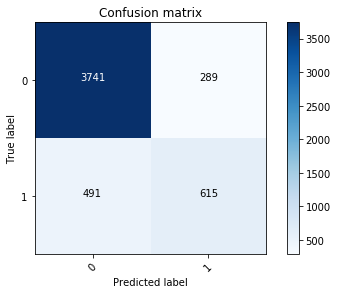

In [123]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, learn.data.classes)

In [124]:
learn.save('learn85ac_res50')

In [18]:
learn.load('learn85ac_res50')

RuntimeError: While copying the parameter named 0.weight, whose dimensions in the model are torch.Size([4096]) and whose dimensions in the checkpoint are torch.Size([64, 3, 7, 7]).